# Upgrade

Este notebook es un upgrade de algunas cosas del otro

In [106]:
import pandas as pd

houses_full = pd.read_csv('Housing.csv')

columns_to_drop = ['id', 'date', 'zipcode', 'lat', 'long']
df_clean = houses_full.drop(columns=columns_to_drop)

current_year = 2015  # Año actual del dataset
df_clean['yr_renovated'] = current_year - df_clean['yr_renovated'].where(df_clean['yr_renovated'] != 0, df_clean['yr_built'])

df_clean['yr_built'] = current_year - df_clean['yr_built']

df_clean.to_csv('housing_clean.csv', index=False)

houses = pd.read_csv('housing_clean.csv')
houses.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400886e+05,3.370795,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,43.994864,41.613982,1986.552492,12768.455652
std,3.671268e+05,0.930105,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,28.806854,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,0.000000,0.000000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,18.000000,16.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,40.000000,38.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,64.000000,61.000000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,115.000000,115.000000,6210.000000,871200.000000


In [127]:
#Asignar por valor a houses_full para no perder la data original
houses = houses_full.copy()

#si houses no tiene la columna zipcode_price_mean crearla
if 'zipcode_price_mean' not in houses.columns:
    zipcode_price_mean = houses.groupby('zipcode')['price'].mean()
    houses['zipcode_price_mean'] = houses['zipcode'].map(zipcode_price_mean)
    houses_full['zipcode_price_mean'] = houses['zipcode_price_mean']

#Quitar los outliers en todas las features
numeric_cols = houses.select_dtypes(include=[np.number]).columns
houses[numeric_cols] = houses[numeric_cols][(np.abs(houses[numeric_cols] - houses[numeric_cols].mean()) / houses[numeric_cols].std()) < 3]
houses_no = houses.dropna().copy()

print(houses_full.shape)
print(houses.shape)
print(houses_no.shape)

(21613, 22)
(21613, 22)
(18484, 22)


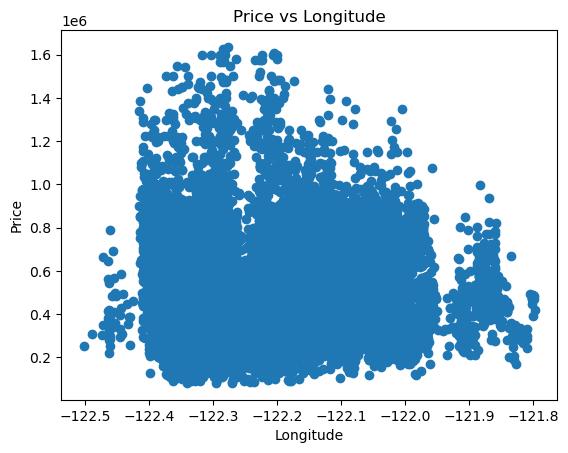

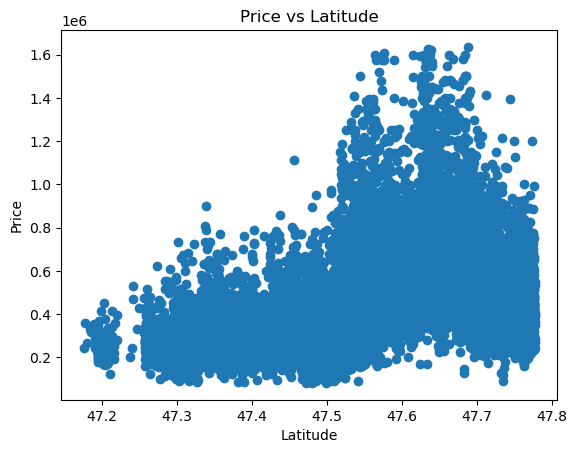

In [110]:
#scatter plot prices vs long and prices vs lat
import matplotlib.pyplot as plt
plt.scatter(houses_no['long'], houses_no['price'])
plt.title('Price vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Price')
plt.show()

plt.scatter(houses_no['lat'], houses_no['price'])
plt.title('Price vs Latitude')
plt.xlabel('Latitude')
plt.ylabel('Price')
plt.show()



In [109]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def linear_regression(X_train, X_test, y_train, y_test, verbose=False):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train, X_train).fit()
    if(verbose):
        print(model.summary())
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_test, y_pred)
    r2_adj = model.rsquared_adj
    return model, mse, r2, r2_adj

In [128]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
from itertools import chain, combinations

# All the columns except for price, id, date, zipcode, waterfront, yr_renovated, sqft_living15, sqft_lot15
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'yr_built', 'zipcode_price_mean']

# Generate all possible subsets of the columns
subsets = chain(*map(lambda x: combinations(columns, x), range(0, len(columns)+1)))

best_mse = np.inf
best_subset = None
best_model = None

# For each subset, perform linear regression and keep track of the one with the lowest MSE
for subset in subsets:
    if len(subset) == 0:
        continue
    X = houses_no[list(subset)]
    # Check if the data type of each column is numeric
    if not all(np.issubdtype(X[col].dtype, np.number) for col in X.columns):
        continue
    y = houses_no['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model, mse, r2, r2_adj = linear_regression(X_train, X_test, y_train, y_test)
    if mse < best_mse:
        best_mse = mse
        best_subset = subset
        best_model = model

print(f'Best MSE: {best_mse}')
print(f'Best subset: {best_subset}')

KeyboardInterrupt: 

In [131]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np

X = houses_no[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'lat', 'long', 'yr_built', 'zipcode_price_mean']]

y = houses_no['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model, mse, r2, r2_adj = linear_regression(X_train, X_test, y_train, y_test, 1)

print(f'MSE: {mse}')
print(f'R^2: {r2}')
print(f'Adjusted R^2: {r2_adj}')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     4563.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:03:11   Log-Likelihood:            -1.9122e+05
No. Observations:               14787   AIC:                         3.825e+05
Df Residuals:                   14773   BIC:                         3.826e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -2.8e+07   1.04

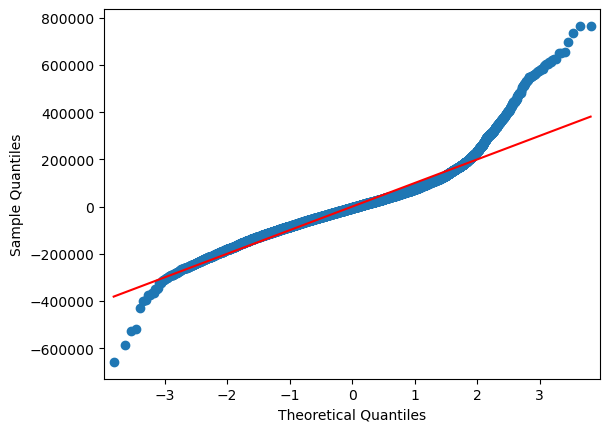

c:\Users\edian\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


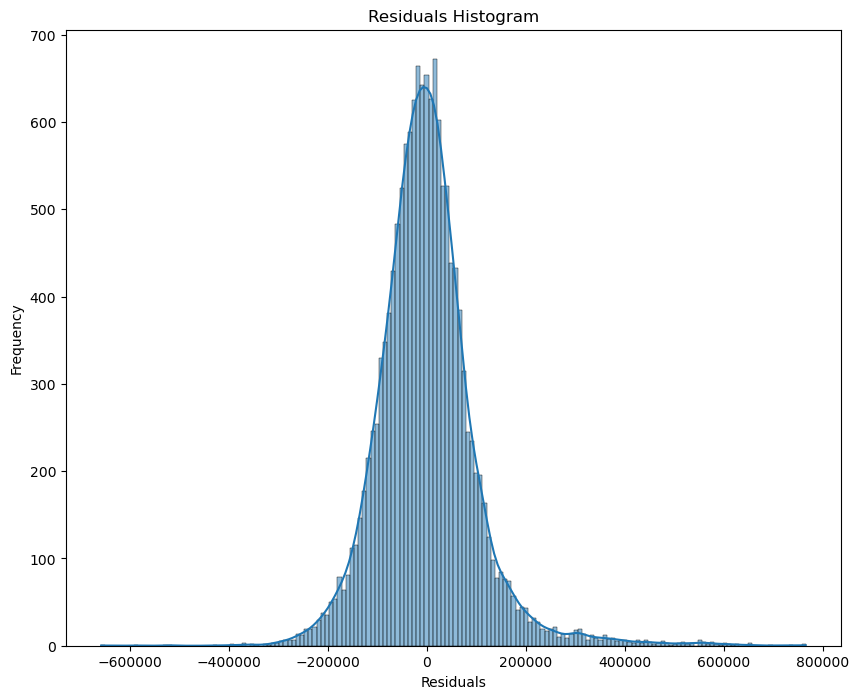

D = 0.5287752755799012, p-value = 0.0
Los residuos no parecen estar normalmente distribuidos. :(


In [70]:
from scipy.stats import kstest
import matplotlib.pyplot as plt
import seaborn as sns


residuals = model.resid
sm.qqplot(residuals, line='s')
plt.show()


plt.figure(figsize=(10, 8))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

D, p_value = kstest(residuals, 'norm')

print(f"D = {D}, p-value = {p_value}")

if p_value > 0.05:
    print("Los residuos parecen estar normalmente distribuidos.")
else:
    print("Los residuos no parecen estar normalmente distribuidos. :(")

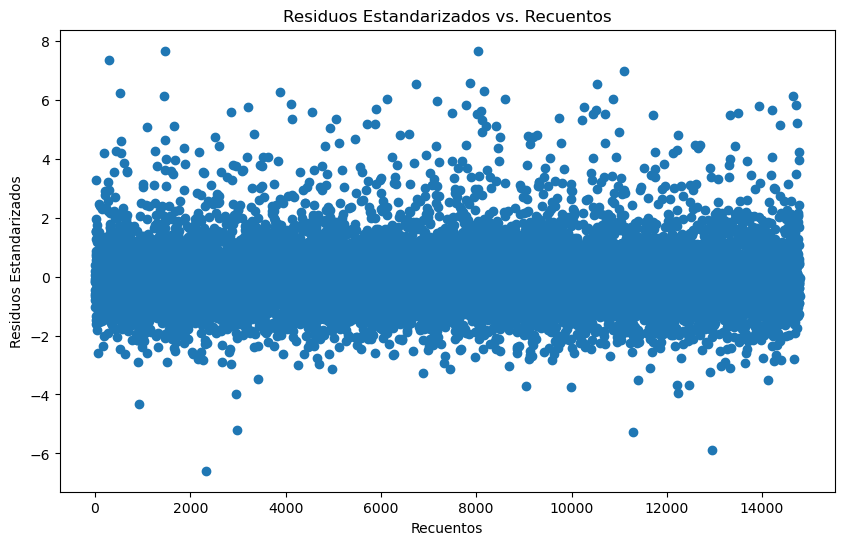

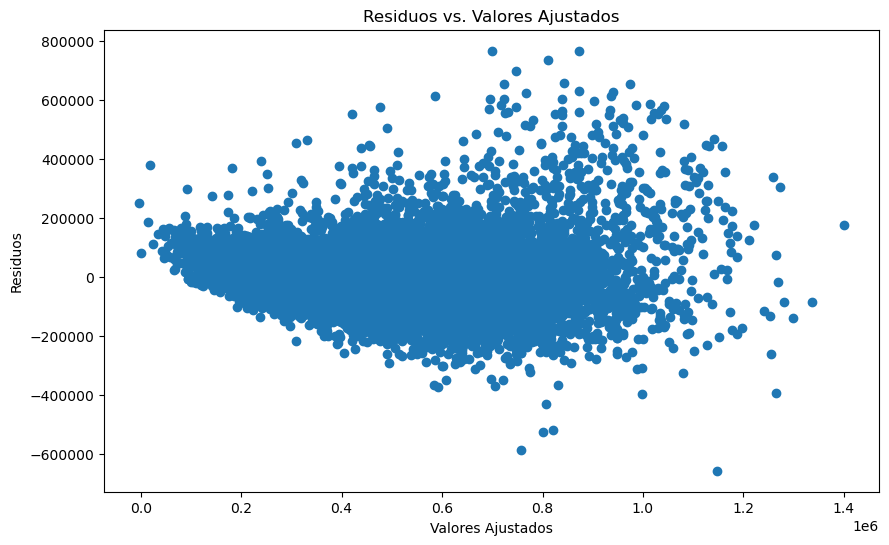

[('Lagrange multiplier statistic', 1533.0117065720854), ('p-value', 0.0), ('f-value', 131.43899632210034), ('f p-value', 0.0)]
Se rechaza la hipótesis nula de homocedasticidad.


In [89]:
# Test de Breusch-Pagan
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

residuos_estandarizados = residuals / np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuos_estandarizados)), residuos_estandarizados)
plt.title('Residuos Estandarizados vs. Recuentos')
plt.xlabel('Recuentos')
plt.ylabel('Residuos Estandarizados')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuals)
plt.title('Residuos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()


names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

print(lzip(names, test))

if test[1] > 0.05:
    print("No se rechaza la hipótesis nula de homocedasticidad.")
else:
    print("Se rechaza la hipótesis nula de homocedasticidad.")



In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

def train_pytorch_model(X_train, X_test, y_train, y_test):
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    class HousePricePredictor(nn.Module):
        def __init__(self):
            super(HousePricePredictor, self).__init__()
            self.fc1 = nn.Linear(X_train.shape[1], 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 32)
            self.fc4 = nn.Linear(32, 1)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    model_torch = HousePricePredictor()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

    best_loss = np.inf
    patience = 50
    patience_counter = 0

    num_epochs = 200
    for epoch in range(num_epochs):
        model_torch.train()
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model_torch(X_batch)
            loss = criterion(y_pred.view(-1), y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model_torch.eval()
    y_pred_tensor = model_torch(X_test_tensor)
    y_pred = y_pred_tensor.view(-1).detach().numpy()
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE: {mse}')

    return model_torch, mse

In [74]:
import xgboost as xgb

def train_xgboost_model(X_train, X_test, y_train, y_test):
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    print(f'MSE: {mse}')

    return model_xgb, mse

In [75]:
from scipy.stats import f_oneway
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


X = houses_no[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'lat', 'long', 'yr_built', 'zipcode_price_mean']]

y = houses_no['price']

kf = KFold(n_splits=3)
mse1=[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    _, mse,_,_ = linear_regression(X_train, X_test, y_train, y_test)
    mse1.append(mse)

kf = KFold(n_splits=3)
mse2= []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    _, mse = train_xgboost_model(X_train, X_test, y_train, y_test)
    mse2.append(mse)

kf = KFold(n_splits=3)
mse3= []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    _, mse = train_pytorch_model(X_train, X_test, y_train, y_test)
    mse3.append(mse)

f_stat, p_value = f_oneway(mse1,mse2,mse3)

if p_value < 0.05:
    print("There is a significant difference between the models.")
else:
    print("There is not a significant difference between the models.")


MSE: 6345563372.061866
MSE: 6323715209.60342
MSE: 6255257305.112665
Epoch 1/200, Loss: 21759100928.0
Epoch 11/200, Loss: 15946274816.0
Epoch 21/200, Loss: 9050083328.0
Epoch 31/200, Loss: 18316994560.0
Epoch 41/200, Loss: 14380640256.0
Epoch 51/200, Loss: 7053550592.0
Epoch 61/200, Loss: 8535050240.0
Epoch 71/200, Loss: 10232012800.0
Epoch 81/200, Loss: 12956511232.0
Epoch 91/200, Loss: 13409090560.0
Epoch 101/200, Loss: 20086845440.0
Epoch 111/200, Loss: 11675386880.0
Epoch 121/200, Loss: 8259961856.0
Epoch 131/200, Loss: 18264420352.0
Early stopping triggered
MSE: 12059368936.326847
Epoch 1/200, Loss: 26359080960.0
Epoch 11/200, Loss: 15092697088.0
Epoch 21/200, Loss: 19826280448.0
Epoch 31/200, Loss: 21507112960.0
Epoch 41/200, Loss: 12465518592.0
Epoch 51/200, Loss: 5846716416.0
Epoch 61/200, Loss: 14410761216.0
Epoch 71/200, Loss: 7995240448.0
Epoch 81/200, Loss: 11116853248.0
Epoch 91/200, Loss: 8122680832.0
Early stopping triggered
MSE: 11550171355.76258
Epoch 1/200, Loss: 25913

In [78]:
#Print the MSE of the models
print(f'MSE Linear Regression: {mse1}')
print(f'MSE XGBoost: {mse2}')
print(f'MSE PyTorch: {mse3}')

MSE Linear Regression: [9.68751419e+09 9.56753006e+09 1.07047144e+10]
MSE XGBoost: [6.34556337e+09 6.32371521e+09 6.25525731e+09]
MSE PyTorch: [1.20593689e+10 1.15501714e+10 1.21012851e+10]


In [76]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mse1 = np.array(mse1)
mse2 = np.array(mse2)
mse3 = np.array(mse3)

data = {'mse': np.concatenate([mse1, mse2, mse3]),
        'model': ['regression'] * 3 + ['xgboost'] * 3 + ['torch'] * 3}

df = pd.DataFrame(data)

model = ols('mse ~ model', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq   df           F    PR(>F)
model     4.851449e+19  2.0  149.512262  0.000008
Residual  9.734551e+17  6.0         NaN       NaN


In [77]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(df['mse'], df['model'], alpha=0.05)
print(posthoc)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
  group1    group2     meandiff     p-adj       lower            upper      reject
----------------------------------------------------------------------------------
regression   torch   1917022222.125 0.0027   907929844.4433 2926114599.8067   True
regression xgboost -3678407600.0377 0.0001 -4687499977.7194 -2669315222.356   True
     torch xgboost -5595429822.1627    0.0 -6604522199.8444 -4586337444.481   True
----------------------------------------------------------------------------------


In [ ]:
from scipy.stats import shapiro

for group in df['model'].unique():
    group_data = df[df['model'] == group]['mse']
    _, p_value = shapiro(group_data)
    if p_value < 0.05:
        print(f"The {group} group is not normally distributed.")
    else:
        print(f"The {group} group is normally distributed.")

from scipy.stats import levene

levene(df[df['model'] == 'regression']['mse'],
         df[df['model'] == 'xgboost']['mse'],
         df[df['model'] == 'torch']['mse'])
if p_value < 0.05:
    print("The groups have different variances.")
else:
    print("The groups have equal variances.")


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

houses_normalized = houses_numeric.dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(houses_normalized)

pca = PCA()

pca.fit(X_scaled)
components = pca.transform(X_scaled)

variance_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(variance_ratio.shape[0]) + 1, variance_ratio)

In [ ]:
cum_variance = pca.explained_variance_ratio_.cumsum()
plt.stem(np.arange(variance_ratio.shape[0]) + 1, cum_variance)
plt.grid()

In [ ]:
component_count = 10
pca = PCA(component_count)
principalComponents = pca.fit_transform(houses_normalized)
principal_Df = pd.DataFrame(data = principalComponents)
analysis = pd.DataFrame(pca.components_, columns=houses_normalized.columns, index=[f'PC{i}' for i in range(1,component_count+1)]).T
sns.heatmap(analysis, vmin=-5e-1, vmax=5e-1)